## Importing Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# !ls /content/drive/'My Drive'/
!cp /content/drive/'My Drive'/image_classification_data.zip .
!unzip -q -o image_classification_data.zip
!rm image_classification_data.zip
!mkdir image_classification_data

Mounted at /content/drive


In [3]:
# Used for Moving Zip Contents to Folder

!mv data_labels_extraData.csv image_classification_data
!mv data_labels_mainData.csv image_classification_data
!mv patch_images image_classification_data
!rm -r sample_data

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

data = pd.read_csv('./image_classification_data/data_labels_mainData.csv')

extra_data = pd.read_csv('./image_classification_data/data_labels_extraData.csv')

combined_isCancer_data = pd.concat([data, extra_data])
combined_isCancer_data.head()


,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0.0,0
1,22406,1,22406.png,fibroblast,0.0,0
2,22407,1,22407.png,fibroblast,0.0,0
3,22408,1,22408.png,fibroblast,0.0,0
4,22409,1,22409.png,fibroblast,0.0,0


## EDA

### Column Names and Data Types


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


### Verify CellType Values

As we can see from the above output - `cellType` is a attribute that turns our categorical attribute `cellTypeName` into an integer value

We will validate whether the mapping was done correctly.

In [ ]:
correlation_dict = {'fibroblast': 0, 'inflammatory': 1, 'epithelial': 2, 'others': 3}

# Produce Expected CellTypeValues using Dictionary
data['expectedCellType'] = data['cellTypeName'].map(correlation_dict)

# Compare Expected with Actual CellType Values
data['results'] = data['cellType'] == data['expectedCellType']

# Print Whether CellType Maps to Expected Value
if(data['results'].sum().all() == True): 
    print("Consistent Mapping of CellType Values")
else:
    print("Inconsistent Mapping of CellType Values")

Consistent Mapping of CellType Values


### Verify If Missing Values Exist

In [ ]:

# Check if Total Null Values Across all Columns are NULL
if(data.isnull().sum().all() == 0): 
    print("No Missing Values")
else:
    print("Missing Values Found")

No Missing Values


In [ ]:
print("Data count by cellTypeName") 
print(data['cellTypeName'].value_counts())

print("Data count by isCancerous")
print(data['isCancerous'].value_counts())

Data count by cellTypeName
epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386
Name: cellTypeName, dtype: int64
Data count by isCancerous
0    5817
1    4079
Name: isCancerous, dtype: int64


# Model 1 - isCancerous


### Splitting Data

In [8]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(combined_isCancer_data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 12168, Val Data: 4056, Test Data: 4056


### Diagnostic Tool

In [9]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()    

### Data Generator 

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

# Scale the Image Pixel Values from 0-1
# Both the Training and Testing Set is Scaled in the Same Way
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='/content/image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='/content/image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


### Baseline Model

In [ ]:
INPUT_DIM = (27,27,3) # 26x26 Pixel Images, 3 Channels (RGB) 
HIDDEN_LAYER_DIM = 256 # Hyper Parameter we can Tune Later
OUTPUT_CLASSES = 2 

Why is sigmoid good for binary classification? compared to other??

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2187)              0         
                                                                 
 dense (Dense)               (None, 256)               560128    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 560,642
Trainable params: 560,642
Non-trainable params: 0
_________________________________________________________________


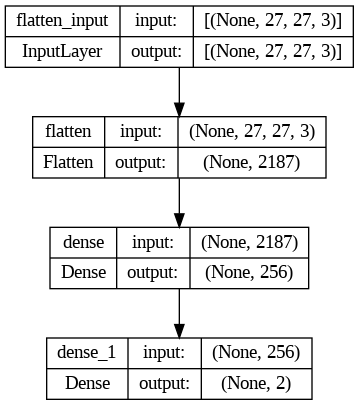

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [ ]:
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=1)

Epoch 1/50


<ipython-input-17-d282d76f89ea>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=1)


381/381 [==============================] - 11s 26ms/step - loss: 0.6199 - categorical_accuracy: 0.6510 - val_loss: 0.5904 - val_categorical_accuracy: 0.6573
Epoch 2/50
381/381 [==============================] - 9s 23ms/step - loss: 0.5737 - categorical_accuracy: 0.6672 - val_loss: 0.5464 - val_categorical_accuracy: 0.7091
Epoch 3/50
381/381 [==============================] - 10s 27ms/step - loss: 0.5303 - categorical_accuracy: 0.7311 - val_loss: 0.5038 - val_categorical_accuracy: 0.7557
Epoch 4/50
381/381 [==============================] - 16s 42ms/step - loss: 0.4897 - categorical_accuracy: 0.7868 - val_loss: 0.4657 - val_categorical_accuracy: 0.8173
Epoch 5/50
251/381 [==================>...........] - ETA: 2s - loss: 0.4579 - categorical_accuracy: 0.8134

KeyboardInterrupt: ignored

In [ ]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

### VGG 1 - Deep Learning Model

In [ ]:
import tensorflow as tf

model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

model_VGG_1.summary()

In [ ]:
tf.keras.utils.plot_model(model_VGG_1, show_shapes=True)

In [ ]:
model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy'])

In [ ]:
history2 = model_VGG_1.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=1)

In [ ]:
plot_learning_curve(history2.history['loss'], history2.history['val_loss'], 
                    history2.history['binary_accuracy'], history2.history['val_binary_accuracy'], 
                    metric_name='Accuracy')

### VGG 2 - Preventing Overfitting

In [ ]:
reg_lambda = 0.001

model_VGG_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [ ]:
model_VGG_2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy'])

In [ ]:
history3 = model_VGG_2.fit_generator(train_generator, validation_data = validation_generator, epochs=30, verbose=1)

Epoch 1/50


<ipython-input-20-695ed4e5378e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history3 = model_VGG_2.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=1)


381/381 [==============================] - 97s 250ms/step - loss: 0.5757 - binary_accuracy: 0.7380 - val_loss: 0.4121 - val_binary_accuracy: 0.8226
Epoch 2/50
 25/381 [>.............................] - ETA: 1:08 - loss: 0.4456 - binary_accuracy: 0.8073

KeyboardInterrupt: ignored

In [ ]:
plot_learning_curve(history3.history['loss'], history3.history['val_loss'], 
                    history3.history['binary_accuracy'], history3.history['val_binary_accuracy'], 
                    metric_name='Accuracy')

# Model Two - Classify Cell Type

## Load the Data

In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


## VGG Model for cellTye

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

# Scale the Image Pixel Values from 0-1
# Both the Training and Testing Set is Scaled in the Same Way
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='/content/image_classification_data/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='/content/image_classification_data/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [ ]:
INPUT_DIM = (27,27,3) # 26x26 Pixel Images, 3 Channels (RGB) 
OUTPUT_CLASSES = 4

In [ ]:
from tensorflow.keras import regularizers

reg_lambda = 0.001

model_VGG_3 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM, 
                           kernel_regularizer=regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 4 
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),


    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', 
                          kernel_regularizer=regularizers.l2(reg_lambda)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [ ]:
model_VGG_3.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [ ]:
history4 = model_VGG_3.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=1)

Epoch 1/50


<ipython-input-37-e14b3466e5c4>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history4 = model_VGG_3.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=1)


186/186 [==============================] - 123s 647ms/step - loss: 1.5366 - categorical_accuracy: 0.4154 - val_loss: 1.3632 - val_categorical_accuracy: 0.4093
Epoch 2/50
186/186 [==============================] - 119s 641ms/step - loss: 1.3316 - categorical_accuracy: 0.4174 - val_loss: 1.3397 - val_categorical_accuracy: 0.4093
Epoch 3/50
186/186 [==============================] - 118s 635ms/step - loss: 1.1968 - categorical_accuracy: 0.4772 - val_loss: 1.3616 - val_categorical_accuracy: 0.4598
Epoch 4/50
186/186 [==============================] - 118s 634ms/step - loss: 1.0790 - categorical_accuracy: 0.5405 - val_loss: 1.1235 - val_categorical_accuracy: 0.5124
Epoch 5/50
186/186 [==============================] - 118s 634ms/step - loss: 1.0208 - categorical_accuracy: 0.5631 - val_loss: 0.9517 - val_categorical_accuracy: 0.5937
Epoch 6/50
186/186 [==============================] - 118s 634ms/step - loss: 0.9731 - categorical_accuracy: 0.5922 - val_loss: 0.9262 - val_categorical_accuracy

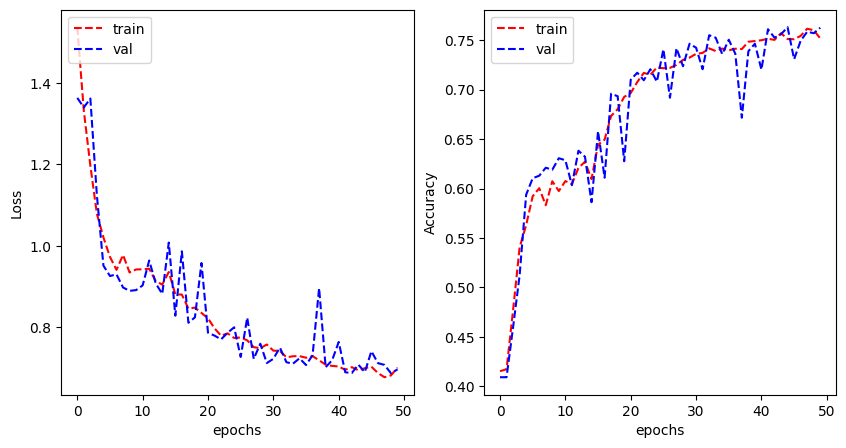

In [ ]:
plot_learning_curve(history4.history['loss'], history4.history['val_loss'], 
                    history4.history['categorical_accuracy'], history4.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

# Transfer learning - Using Extra Data File to assist classifynig cell-tye

In [ ]:
model_VGG_3.save_weights('model_weights.h5')

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Scale the Image Pixel Values from 0-1
# Both the Training and Testing Set is Scaled in the Same Way
extra_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

extra_generator = extra_datagen.flow_from_dataframe(
    extra_data,
    directory='/content/image_classification_data/patch_images',
    x_col='ImageName',
    target_size=(27, 27),
    class_mode=None,
    batch_size=32,
    shuffle=False)

Found 10384 validated image filenames.


In [ ]:
model_VGG_3.load_weights('model_weights.h5')
predictions = model_VGG_3.predict(extra_generator)
predicted_classes = np.argmax(predictions, axis=1)

extra_data['cellType'] = predicted_classes
extra_data.head()

325/325 [==============================] - 43s 132ms/step


,InstanceID,patientID,ImageName,isCancerous,cellType
0,12681,61,12681.png,0,0
1,12682,61,12682.png,0,0
2,12683,61,12683.png,0,0
3,12684,61,12684.png,0,0
4,12685,61,12685.png,0,0


In [ ]:
combined_df = pd.concat([data, extra_data])
combined_df.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,expectedCellType,results
0,22405,1,22405.png,fibroblast,0,0,0.0,True
1,22406,1,22406.png,fibroblast,0,0,0.0,True
2,22407,1,22407.png,fibroblast,0,0,0.0,True
3,22408,1,22408.png,fibroblast,0,0,0.0,True
4,22409,1,22409.png,fibroblast,0,0,0.0,True


In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(combined_df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 12168, Val Data: 4056, Test Data: 4056


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

# Scale the Image Pixel Values from 0-1
# Both the Training and Testing Set is Scaled in the Same Way
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='/content/image_classification_data/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='/content/image_classification_data/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 12168 validated image filenames belonging to 4 classes.
Found 4056 validated image filenames belonging to 4 classes.


In [ ]:
history5 = model_VGG_3.fit_generator(train_generator, validation_data = validation_generator, epochs=20, verbose=1)

Epoch 1/20


<ipython-input-45-64cc1dc5cbb1>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history5 = model_VGG_3.fit_generator(train_generator, validation_data = validation_generator, epochs=20, verbose=1)


381/381 [==============================] - 249s 654ms/step - loss: 0.5449 - categorical_accuracy: 0.8291 - val_loss: 0.5059 - val_categorical_accuracy: 0.8444
Epoch 2/20
381/381 [==============================] - 309s 812ms/step - loss: 0.5352 - categorical_accuracy: 0.8301 - val_loss: 0.5162 - val_categorical_accuracy: 0.8417
Epoch 3/20
381/381 [==============================] - 247s 649ms/step - loss: 0.5219 - categorical_accuracy: 0.8367 - val_loss: 0.5420 - val_categorical_accuracy: 0.8205
Epoch 4/20
381/381 [==============================] - 245s 644ms/step - loss: 0.5181 - categorical_accuracy: 0.8405 - val_loss: 0.5046 - val_categorical_accuracy: 0.8402
Epoch 5/20
381/381 [==============================] - 239s 627ms/step - loss: 0.5189 - categorical_accuracy: 0.8350 - val_loss: 0.4962 - val_categorical_accuracy: 0.8521
Epoch 6/20
381/381 [==============================] - 250s 655ms/step - loss: 0.5150 - categorical_accuracy: 0.8408 - val_loss: 0.5070 - val_categorical_accuracy

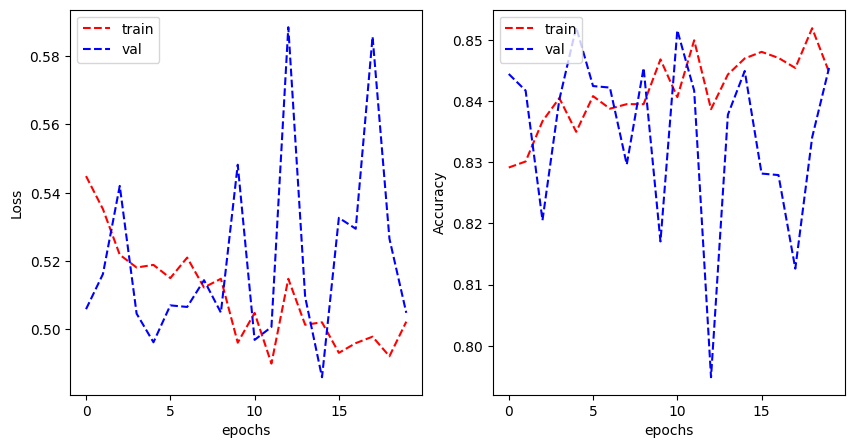

In [ ]:
plot_learning_curve(history5.history['loss'], history5.history['val_loss'], 
                    history5.history['categorical_accuracy'], history5.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

# Testing

## Model 1

In [10]:
test_data['isCancerous'] = test_data['isCancerous'].astype('str')

# Scale the Image Pixel Values from 0-1
# Both the Training and Testing Set is Scaled in the Same Way
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

testing_generator = val_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='/content/image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

NameError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

true_labels = testing_generator.labels

# Generate predictions using the model
y_pred = model_VGG_2.predict(testing_generator)
y_pred_classes = y_pred.argmax(axis=1)

# Calculate confusion matrix
cm = confusion_matrix(true_labels, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Model 2

In [ ]:
test_data['cellType'] = test_data['cellType'].astype('str')

# Scale the Image Pixel Values from 0-1
# Both the Training and Testing Set is Scaled in the Same Way
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='/content/image_classification_data/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

In [ ]:
true_labels = testing_generator.labels

# Generate predictions using the model
y_pred = model_VGG_3.predict(testing_generator)
y_pred_classes = y_pred.argmax(axis=1)

# Calculate confusion matrix
cm = confusion_matrix(true_labels, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()